# Comparison Graph

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from sklearn.model_selection import train_test_split
from sklearn import metrics
import math
import findspark
findspark.init()
import pyspark
from pyspark.sql.functions import col,isnan, when, count
from pyspark.sql import SparkSession 
from pyspark.sql.types import * 
from pyspark.sql.functions import *
import joblib

# Configure spark session

spark = SparkSession\
    .builder\
    .master('local[2]')\
    .appName('quake_etl')\
    .config('spark.jars.package', 'org.mongodb.spark:mongo-spark-connector 2.12:2.4.1')\
    .getOrCreate()


In [2]:
def svm(X,y):
    #Seperating X and y
    # Splitting the dataset
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

    # Support Vector Machine
    global y_test_svm
    y_train_svm= y_train[['Magnitude']]*10
    y_test_svm= y_test[['Magnitude']]*10

    # Implementing SVM

    from sklearn.svm import SVR
    regressor = SVR(kernel = 'rbf')
    regressor.fit(X_train, y_train_svm.values.ravel())
    global y_pred_svm
    y_pred_svm=regressor.predict(X_test)
    y_pred_svm=pd.DataFrame(y_pred_svm)
    result=y_test_svm['Magnitude']/10
    y_pred_svm.columns=["Predicted values"]
    y_pred_svm/=10
    result = pd.concat([result.reset_index(drop='True'),y_pred_svm.reset_index(drop='True')],axis=1)
    for i in result.columns:
        result[i] = result[i].round(decimals = 0)
    return metrics.accuracy_score(result[['Magnitude']], result[['Predicted values']])

In [3]:
# Implementing Decision Tree
def dc(X,y):
    from sklearn.tree import DecisionTreeRegressor
    from sklearn import tree
    # Splitting the dataset
    global y_test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

    dtr=DecisionTreeRegressor(random_state=0)

    dtr.fit(X_train,y_train)
    y_pred_dc=dtr.predict(X_test)

    global y_pred_dcr
    y_pred_dcr=pd.DataFrame(y_pred_dc)
    result=y_test['Magnitude']
    y_pred_dcr.columns=["Predicted values"]
    result = pd.concat([result.reset_index(drop='True'),y_pred_dcr.reset_index(drop='True')],axis=1)
    for i in result.columns:
        result[i] = result[i].round(decimals = 0)

    #Model Validations
    return metrics.accuracy_score(result[['Magnitude']], result[['Predicted values']])
  

In [4]:
def rf(df_t1,n):
 
    df_t2=joblib.load('joblibs/rftest.joblib')
    df_train=spark.createDataFrame(df_t1)
    df_test=spark.createDataFrame(df_t2.head(n))
    from pyspark.ml import Pipeline
    from pyspark.ml.regression import RandomForestRegressor
    from pyspark.ml.feature import VectorAssembler
    from pyspark.ml.evaluation import RegressionEvaluator

    assembler = VectorAssembler(inputCols=['Latitude', 'Longitude', 'Depth'], outputCol='features')

    # Create the model

    model_reg=RandomForestRegressor(featuresCol='features', labelCol='Magnitude')

    # Chain the assembler with the model in a pipeline 
    pipeline=Pipeline(stages=[assembler, model_reg])

    # Train the Model
    model=pipeline.fit(df_train)

    # Make the prediction
    pred_results_RF = model.transform(df_test)
    global df_test_rf
    df_test_rf=df_test.toPandas()
    global pred_results_RFR
    pred_results_RFR=pred_results_RF.toPandas()
    result = pd.concat([df_test_rf[['Magnitude']].reset_index(drop='True'),pred_results_RFR[['prediction']].reset_index(drop='True')],axis=1)
    for i in result.columns:
        result[i] = result[i].round(decimals = 0)

    
    accuracy_rf=metrics.accuracy_score(result[['Magnitude']], result[['prediction']])
    return accuracy_rf

In [5]:
# K Nearest Neighbors Regression
class K_Nearest_Neighbors_Regressor() : 
    def __init__( self, K ) :
          
        self.K = K
          
    # Function to store training set
          
    def fit( self, X_train, Y_train ) :
          
        self.X_train = X_train
          
        self.Y_train = Y_train
          
        # no_of_training_examples, no_of_features
          
        self.m, self.n = X_train.shape
      
    # Function for prediction
          
    def predict( self, X_test ) :
        self.X_test = X_test
        # no_of_test_examples, no_of_features
        self.m_test, self.n = X_test.shape
        # initialize Y_predict
        Y_predict = np.zeros( self.m_test )
        for i in range( self.m_test ) :
            x = self.X_test[i]
            # find the K nearest neighbors from current test example
            neighbors = np.zeros( self.K )
            neighbors = self.find_neighbors( x )
            # calculate the mean of K nearest neighbors
            Y_predict[i] = np.mean( neighbors )
              
        return Y_predict
      
    # Function to find the K nearest neighbors to current test example
            
    def find_neighbors( self, x ) :
        # calculate all the euclidean distances between current test
        # example x and training set X_train
        euclidean_distances = np.zeros( self.m )
        for i in range( self.m ) :
            d = self.euclidean( x, self.X_train[i] )
            euclidean_distances[i] = d
        
        
        # sort Y_train according to euclidean_distance_array and 
        # store into Y_train_sorted
        inds = euclidean_distances.argsort()
        Y_train_sorted = self.Y_train[inds]
        return Y_train_sorted[:self.K]
      
    # Function to calculate euclidean distance
              
    def euclidean( self, x, x_train ) :
        return np.sqrt( np.sum( np.square( x - x_train ) ) )

# Driver code
def knn(X,Y): 
   
    # Splitting dataset into train and test set
  
    X_train, X_test, Y_train, Y_test = train_test_split( 
      X, Y, test_size = 1/3, random_state = 0 )
      
    # Model training
      
    model = K_Nearest_Neighbors_Regressor( K = 9 )
    model.fit( X_train, Y_train )

    #  Prediction on test set
  
    Y_pred = model.predict( X_test )
    #Predcition Results
    Y_pred_knn=pd.DataFrame(Y_pred)
    Y_pred_knn.columns=["Predicted values"]
    Y_test_knn=pd.DataFrame(Y_test)
    Y_test_knn.columns=['Magnitude']
    result=Y_test_knn['Magnitude']
    result = pd.concat([result.reset_index(drop='True'),Y_pred_knn.reset_index(drop='True')],axis=1)
    
    for i in result.columns:
        result[i] = result[i].round(decimals = 0)
    accuracy_knn=metrics.accuracy_score(result[['Magnitude']], result[['Predicted values']])
    
    return accuracy_knn
def findknn(df):
    
    Y_test=joblib.load('joblibs/KNN/knntest.joblib')
    Y_pred = joblib.load('joblibs/KNN/knnpred.joblib')
#Predcition Results
    Y_pred_knn=pd.DataFrame(Y_pred)
    Y_pred_knn.columns=["Predicted values"]
    Y_test_knn=pd.DataFrame(Y_test)
    Y_test_knn.columns=['Magnitude']
    result=Y_test_knn['Magnitude']
    result = pd.concat([result.reset_index(drop='True'),Y_pred_knn.reset_index(drop='True')],axis=1)
    
    
    for i in result.columns:
        result[i] = result[i].round(decimals = 0)
    accuracy_knn=metrics.accuracy_score(result[['Magnitude']], result[['Predicted values']])
    
    return accuracy_knn

In [6]:
def accuracy(a):
    return (a*100).round(decimals=2)

In [7]:
def gplot(h,t,tt,n,name):
    H=accuracy(h)
    T=accuracy(t)
    TT=accuracy(tt)
    N=accuracy(n)
    dat = pd.DataFrame({'alg':['100 records','1000 records','10000 Records','20000 records'],'per': [H,T,TT,N]})
    percentage = [H,T,TT,N]
    dat['Percentage'] = percentage
    plt.figure(figsize=(6,6))
    colors_list = ['red','blue','green','yellow']
    graph = plt.bar(dat.alg,dat.per,color = colors_list)
    plt.title('Percentage of Accuracy Predicted By '+name+' for different size of Dataset ')
    i = 0
    for p in graph:
        width = p.get_width()
        height = p.get_height()
        x, y = p.get_xy()
        plt.text(x+width/2,
                y+height*1.01,
                str(dat.Percentage[i])+'%',
                ha='center',
                weight='bold')
        i+=1
    plt.ylim(0,100)
    plt.xlabel('No.of Records in Dataset')
    plt.ylabel('Accuracy')
    plt.show()

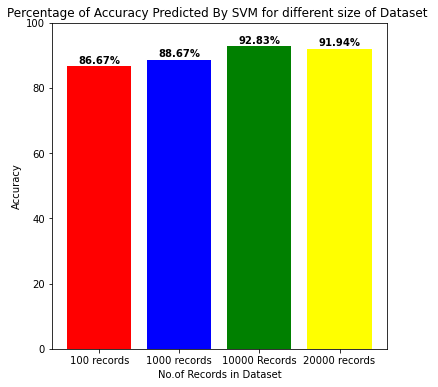

In [9]:
df=joblib.load('joblibs/df.joblib')
X=df[['Year','Latitude','Longitude','Depth']]
y=df[['Magnitude']]

svmh=svm(X.head(100),y.head(100))
svmt=svm(X.head(1000),y.head(1000))
svmtt=svm(X.head(10000),y.head(10000))
svmn=svm(X,y)

gplot(svmh,svmt,svmtt,svmn,"SVM")





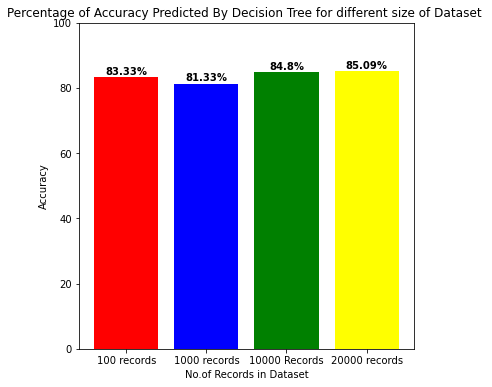

In [10]:
dch=dc(X.head(100),y.head(100))
dct=dc(X.head(1000),y.head(1000))
dctt=dc(X.head(10000),y.head(10000))
dcn=dc(X,y)
gplot(dch,dct,dctt,dcn,"Decision Tree")

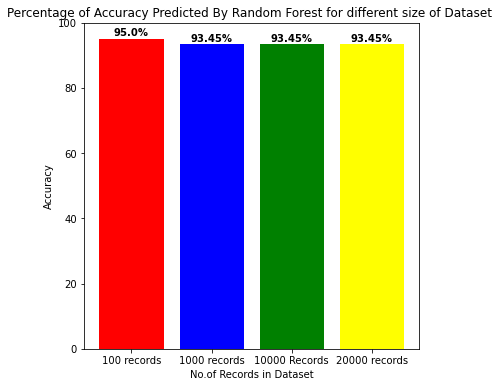

In [11]:
rfh=rf(df.head(100),100)
rft=rf(df.head(1000),1000)
rftt=rf(df.head(10000),10000)
rfn=rf(df,df.shape[0])
gplot(rfh,rft,rftt,rfn,"Random Forest")

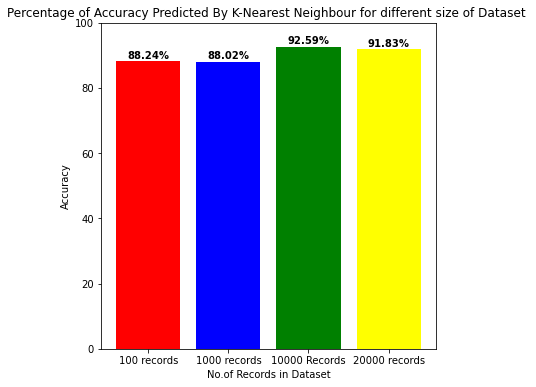

In [27]:

knnh=knn(X.head(100).values,y.head(100).values)
knnt=knn(X.head(1000).values,y.head(1000).values)
knntt=knn(X.head(10000).values,y.head(10000).values)
knnn=findknn(df)
gplot(knnh,knnt,knntt,knnn,"K-Nearest Neighbour")

In [28]:
def compgraph(X_ax,Y_ax,title):
    plt.xlim(5, 10)
    plt.ylim(5, 10)

    # Plot
    # Add labels
    plt.scatter(X_ax, Y_ax, color='blue')
    plt.xlabel("Predicted Values")
    plt.ylabel("Actual Values")
    plt.title("Comaprison Graph for "+str(title))
    # Display

    plt.show()

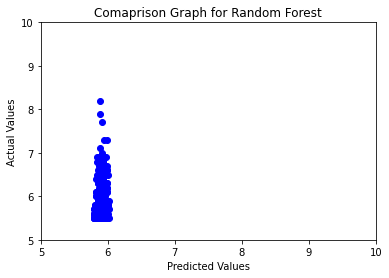

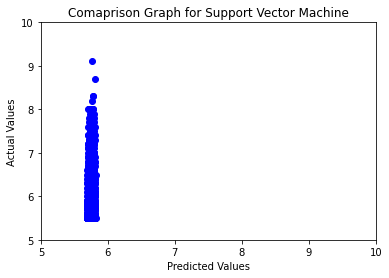

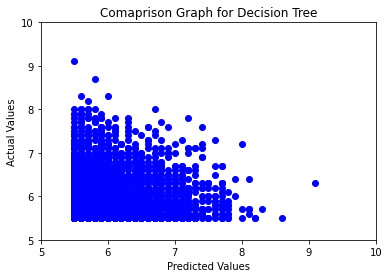

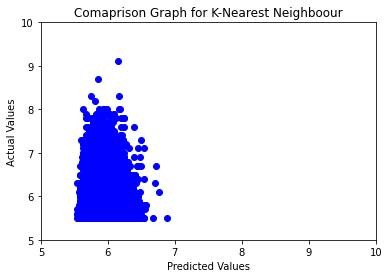

In [29]:
compgraph(pred_results_RFR[['prediction']],df_test_rf[['Magnitude']],"Random Forest")
compgraph(y_pred_svm,y_test_svm['Magnitude']/10,"Support Vector Machine")
compgraph(y_pred_dcr,y_test[['Magnitude']],"Decision Tree")
Y_test=joblib.load('joblibs/KNN/knntest.joblib')
Y_pred = joblib.load('joblibs/KNN/knnpred.joblib')
Y_pred=pd.DataFrame(Y_pred)
Y_test=pd.DataFrame(Y_test)
compgraph(Y_pred,Y_test ,"K-Nearest Neighboour")

